In [10]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from SFM import SFM
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from sfm_helpers import Rec as r
from sfm_helpers import BA as ba
import pandas as pd
import pyntcloud
%matplotlib inline
mpl.rcParams['figure.dpi']= 200

In [2]:
# path = "test1/imgs"
path, K = "datasets/templeRing", np.matrix('1520.40 0.00 302.32; 0.00 1525.90 246.87; 0.00 0.00 1.00')
# path = "test1/7_1b_imgs_4"


test1 = SFM(path, K)

templeR_par.txt: 100%|██████████| 49/49 [00:00<00:00, 79.36it/s]


README.txt is not an img...

templeR_ang.txt is not an img...

templeR_par.txt is not an img...



In [3]:
kp, des = test1.ft_extract()



FEATURE EXTRACTION....


Image 1:   0%|          | 0/46 [00:00<?, ?it/s]

Image 46: 100%|██████████| 46/46 [00:03<00:00, 13.71it/s]


In [4]:
i=0 #ith img
n_ft = des[i][1].shape[0]


j=0 #jth feature
x = des[i][0][j].pt[0]
y = des[i][0][j].pt[1]
scale = des[i][0][j].size
scale = des[i][0][j].angle

D = des[i][1][j]

In [5]:
matches = test1.ft_match()


MATCHING...



(0, 1):   0%|          | 0/45 [00:00<?, ?it/s]

(44, 45): 100%|██████████| 45/45 [00:23<00:00,  1.94it/s]                         

Elapsed Time: 23.1892409324646




In [120]:
lol = matches[(0,1)][24]


In [122]:
'''
img1.png img2.png
queryIdx trainIdx
...
<empty-line>


'''

77

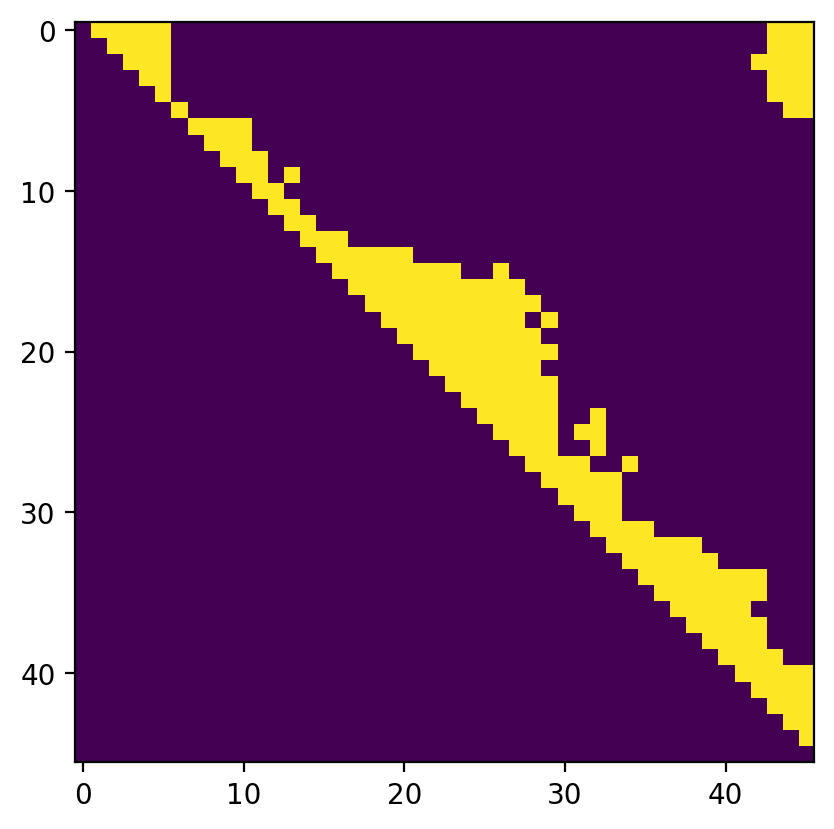

In [6]:
adj_list, pairs = test1.adj_list()
plt.imshow(adj_list)

In [7]:
bpair = r.best_pair(test1.adj, test1.good, test1.kp, test1.K)

r0, t0, r1, t1, p3d_with_views = r.init_rec(test1.kp, test1.good, test1.K, bpair[0], bpair[1])
R_mats = {bpair[0]: r0, bpair[1]: r1}
t_vecs = {bpair[0]: t0, bpair[1]: t1}

resec_img = [bpair[0], bpair[1]]
unres_img = [i for i in range(len(test1.im)) if i not in resec_img]

n_imgs = test1.n
avg_err = 0

In [8]:

BA_chkpts = [3,4,5,6] + [int(6*(1.34**i)) for i in range(25)]
inc = 0
while len(unres_img) > 0:
    res_idx, unres_idx, prepend = r.nxt_img_pair_to_grow_recon(n_imgs, bpair, resec_img, unres_img, adj_list, inc)
    p3d_with_views, p3d_for_pnp, p2d_for_pnp, tri_stat = r.get_corr_for_pnp(res_idx, unres_idx, p3d_with_views, matches, kp)

    if len(p3d_for_pnp) < 12:
        print(f"Too few correspondences: {res_idx, unres_idx}")
        inc += 1
        unres_img.remove(unres_idx)
        # print(f"<{len(p3d_for_pnp)}>", sep=" ")
        continue

    # print(len(unres_img), sep=" ")
    R_res = R_mats[res_idx]
    t_res = t_vecs[res_idx]

    R_new, t_new = r.do_pnp(p3d_for_pnp, p2d_for_pnp, test1.K)
    
    R_mats[unres_idx] = R_new
    t_vecs[unres_idx] = t_new

    if prepend == True:
        resec_img.insert(0, unres_idx)
    else:
        resec_img.append(unres_idx)

    
    unres_img.remove(unres_idx)
    

    pnp_err, proj_pts, avg_err, perc_inl = r.test_reproj_pnp_pts(p3d_for_pnp, p2d_for_pnp, R_new, t_new, K)


    if res_idx < unres_idx:
        kp1, kp2, kp1_idx, kp2_idx = r.get_aligned_pts(res_idx, unres_idx, kp, matches, mask=tri_stat)
        if np.sum(tri_stat) > 0: # at least one point needs to be triangulated
            p3d_with_views, tri_err, avg_tri_err_l, avg_tri_err_r = r.triangulate_pts_and_reproj(
                R_res, t_res, R_new, t_new, K, p3d_with_views, res_idx, unres_idx, kp1, kp2, kp1_idx, kp2_idx, reproj=True
            )
    else:
        kp1, kp2, kp1_idx, kp2_idx = r.get_aligned_pts(unres_idx, res_idx, kp, matches, mask=tri_stat)
        if np.sum(tri_stat) > 0: # at least one point needs to be triangulated
            p3d_with_views, tri_err, avg_tri_err_l, avg_tri_err_r = r.triangulate_pts_and_reproj(
                R_new, t_new, R_res, t_res, K, p3d_with_views, unres_idx, res_idx, kp1, kp2, kp1_idx, kp2_idx, reproj=True
            )

    if (0.8 < perc_inl < 0.95) or (5 < avg_tri_err_l < 10) or (5 < avg_tri_err_r < 10):
        p3d_with_views, R_mats, t_vecs = ba.do_BA(
            p3d_with_views, R_mats, t_vecs, resec_img, kp, K, ftol=1e0
        )

    if (len(resec_img) in BA_chkpts) or (len(unres_img) == 0) or (perc_inl <= 0.8) or (avg_tri_err_l >= 10) or (avg_tri_err_r >= 10):
        p3d_with_views, R_mats, t_vecs = ba.do_BA(
            p3d_with_views, R_mats, t_vecs, resec_img, kp, K, ftol=1e-1
        )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0212e+06                                    1.60e+07    
       1              2         8.8752e+04      1.93e+06       8.74e+00       1.98e+06    
       2              3         8.8057e+02      8.79e+04       3.97e+00       1.42e+05    
       3              5         6.4891e+02      2.32e+02       1.75e+00       7.98e+04    
       4              6         5.4411e+02      1.05e+02       2.84e+00       1.61e+05    
       5              7         4.5079e+02      9.33e+01       8.29e-01       5.11e+04    
       6              8         3.8695e+02      6.38e+01       4.87e-01       1.90e+04    
       7              9         3.8408e+02      2.88e+00       2.71e-01       7.18e+03    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 2.0212e+06, final cost 3.8408e+02, first-order optimality 7.18e+03.
   Iteration     Total nfev      

In [ ]:
n_vox = 200 #100 for faster vis, 200 for higher res

x, y, z = [], [], []


for pt3 in p3d_with_views:
    if abs(pt3.p3d[0][0]) + abs(pt3.p3d[0][1]) + abs(pt3.p3d[0][2]) < 100:
        x.append(pt3.p3d[0][0])
        y.append(pt3.p3d[0][1])
        z.append(pt3.p3d[0][2])


vpoints = list(zip(x,y,z))
vpoints = np.array(vpoints)
vpoints_df = pd.DataFrame(data=vpoints, index=[f"{i}" for i in range(vpoints.shape[0])], columns=["x", "y","z"])
cloud = pyntcloud.PyntCloud(vpoints_df)
cloud.add_structure('voxelgrid', n_x=n_vox,n_y=n_vox,n_z=n_vox)
cloud.structures[f'V([{n_vox}, {n_vox}, {n_vox}],[None, None, None],True)'].plot(d=3)